<a href="https://colab.research.google.com/github/BayramovaNazrin/test1/blob/main/graphsage_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup & Clone**

In [3]:
%cd /content
!rm -rf test1
!git clone https://github.com/BayramovaNazrin/test1.git
%cd /content/test1

/content
Cloning into 'test1'...
remote: Enumerating objects: 173, done.
remote: Counting objects: 100% (173/173), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 173 (delta 70), reused 54 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (173/173), 5.48 MiB | 22.28 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/test1


In [4]:
import sys, os, warnings, copy, time, itertools, random
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, precision_recall_curve
)

warnings.filterwarnings("ignore")
torch.manual_seed(42); np.random.seed(42); random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [5]:
try:
    import torch_geometric
    from torch_geometric.data import Data
    from torch_geometric.nn import SAGEConv
except Exception:
    import torch
    %pip -q install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    from torch_geometric.data import Data
    from torch_geometric.nn import SAGEConv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 120.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 118.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.6 MB/s eta 0:00:00


# **Load Data**

In [6]:
from load_data import load_data
features_df, edges_df, classes_df, merged_df = load_data()

for need, df in [({"txId"}, features_df),
                 ({"txId1","txId2"}, edges_df),
                 ({"txId","class"}, classes_df)]:
    miss = need - set(df.columns)
    if miss:
        raise RuntimeError(f"Missing columns {miss} in dataframe")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Build Graph Data (x, y, edge_index) + Train/Val/Test Masks**

In [8]:
# Node ids & mapping
node_ids = features_df["txId"].to_numpy()
if len(node_ids) != len(np.unique(node_ids)):
    raise RuntimeError("Duplicate txId values in features_df")

node_id_map = {tx: i for i, tx in enumerate(node_ids)}

# Feature matrix X from model_cols (drop id/time)
drop_cols = [c for c in ["txId", "Time step"] if c in features_df.columns]
model_cols = [c for c in features_df.columns if c not in drop_cols]

X = (features_df[model_cols]
     .apply(pd.to_numeric, errors="coerce")
     .fillna(0.0)
     .to_numpy(dtype=np.float32))
x = torch.from_numpy(X)

# Labels: map {1->1 illicit, 2->0 licit}, unknown -> -1
cls = classes_df[classes_df["class"].isin([1,2])][["txId","class"]].copy()
y_arr = np.full(len(node_ids), -1, dtype=np.int64)
for tx, c in zip(cls["txId"].to_numpy(), cls["class"].to_numpy()):
    idx = node_id_map.get(tx)
    if idx is not None:
        y_arr[idx] = 1 if c == 1 else 0
y = torch.from_numpy(y_arr)

# Edges -> edge_index [2, E]
e = edges_df[["txId1","txId2"]].dropna()
e = e[e["txId1"].isin(node_id_map) & e["txId2"].isin(node_id_map)]
edge_index = torch.tensor([[node_id_map[s], node_id_map[t]] for s,t in zip(e["txId1"], e["txId2"])],
                          dtype=torch.long).t().contiguous()

# Masks: time-based split if Time step exists; carve val from train; else stratified
if "Time step" in features_df.columns:
    steps = features_df["Time step"].to_numpy()
    labeled_mask = (y_arr >= 0)

    train_total = (steps <= 34) & labeled_mask
    test_mask_np = (steps > 34) & labeled_mask

    tr_idx = np.where(train_total)[0]
    tr_lab = y_arr[tr_idx]
    tr_in, val_in = train_test_split(tr_idx, test_size=0.2, random_state=42, stratify=tr_lab)

    train_mask = torch.zeros(len(node_ids), dtype=torch.bool); train_mask[tr_in] = True
    val_mask   = torch.zeros(len(node_ids), dtype=torch.bool); val_mask[val_in] = True
    test_mask  = torch.from_numpy(test_mask_np.astype(bool))
else:
    labeled_idx = np.where(y_arr >= 0)[0]
    tr, te = train_test_split(labeled_idx, test_size=0.3, random_state=42, stratify=y_arr[labeled_idx])
    tr, va = train_test_split(tr, test_size=0.2, random_state=42, stratify=y_arr[tr])

    train_mask = torch.zeros(len(node_ids), dtype=torch.bool); train_mask[tr] = True
    val_mask   = torch.zeros(len(node_ids), dtype=torch.bool); val_mask[va] = True
    test_mask  = torch.zeros(len(node_ids), dtype=torch.bool); test_mask[te] = True

graph_data = Data(x=x, edge_index=edge_index, y=y,
                  train_mask=train_mask, test_mask=test_mask)
graph_data.val_mask = val_mask
graph_data = graph_data.to(device)

print(graph_data)
print("features used:", len(model_cols))
print("labeled:", int((y>=0).sum()),
      "| train:", int(train_mask.sum()),
      "val:", int(val_mask.sum()),
      "test:", int(test_mask.sum()))


Data(x=[203769, 166], edge_index=[2, 234355], y=[203769], train_mask=[203769], test_mask=[203769], val_mask=[203769])
features used: 166
labeled: 46564 | train: 26075 val: 6519 test: 13970


# **Model Definitions & Train/Test Helpers**

In [9]:
from torch_geometric.nn import SAGEConv

class GraphSAGE2(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index); x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class FlexibleGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2, dropout=0.5):
        super().__init__()
        assert num_layers >= 2
        self.convs = torch.nn.ModuleList([SAGEConv(in_channels, hidden_channels)])
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = F.relu(conv(x, edge_index))
            x = F.dropout(x, p=self.dropout, training=self.training)
        return self.convs[-1](x, edge_index)

def train_step(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward(); optimizer.step()
    return loss.item()

@torch.no_grad()
def eval_on_mask(model, data, mask):
    model.eval()
    out = model(data.x, data.edge_index)
    probs = F.softmax(out, dim=1)[:,1].detach().cpu().numpy()
    labels = data.y.detach().cpu().numpy()
    m = mask.detach().cpu().numpy()
    preds = (probs[m] >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(labels[m], preds),
        "precision": precision_score(labels[m], preds, zero_division=0),
        "recall": recall_score(labels[m], preds, zero_division=0),
        "f1": f1_score(labels[m], preds, zero_division=0),
        "roc_auc": roc_auc_score(labels[m], probs[m]),
        "pr_auc": average_precision_score(labels[m], probs[m]),
    }

def evaluate_masks(model, data):
    return {"val":  eval_on_mask(model, data, data.val_mask),
            "test": eval_on_mask(model, data, data.test_mask)}


# **Robust Class Weights (Train Only)**

In [10]:
train_labels = graph_data.y[graph_data.train_mask]
num_pos = int((train_labels == 1).sum().item())
num_neg = int((train_labels == 0).sum().item())
if num_pos == 0:
    class_weights = torch.tensor([1.0, 1.0], dtype=torch.float, device=device)
else:
    pos_weight = num_neg / num_pos
    class_weights = torch.tensor([1.0, pos_weight], dtype=torch.float, device=device)

print("Train counts -> licit(0):", num_neg, " illicit(1):", num_pos, "| pos_weight:", float(class_weights[1]))


Train counts -> licit(0): 23530  illicit(1): 2545 | pos_weight: 9.245579719543457


# **Baseline Training + Validation Monitoring**

In [11]:
base_model = GraphSAGE2(
    in_channels=graph_data.num_node_features,
    hidden_channels=128,
    out_channels=2,
    dropout=0.5
).to(device)

optimizer = torch.optim.Adam(base_model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

best_state = None
best_val_prauc = -1.0
patience, patience_ctr = 20, 0
max_epochs = 150

for ep in range(1, max_epochs+1):
    loss = train_step(base_model, graph_data, optimizer, criterion)
    if ep % 5 == 0:
        m = evaluate_masks(base_model, graph_data)
        val_prauc = m["val"]["pr_auc"]
        if val_prauc > best_val_prauc:
            best_val_prauc = val_prauc
            best_state = copy.deepcopy(base_model.state_dict())
            patience_ctr = 0
        else:
            patience_ctr += 1
        if ep % 20 == 0:
            print(f"ep {ep:03d} | loss {loss:.4f} | val F1 {m['val']['f1']:.4f} | val PR-AUC {m['val']['pr_auc']:.4f}")
        if patience_ctr >= patience:
            break

if best_state is not None:
    base_model.load_state_dict(best_state)

final_baseline = evaluate_masks(base_model, graph_data)
print("Baseline VAL:", {k: round(v,4) for k,v in final_baseline["val"].items()})
print("Baseline TEST:", {k: round(v,4) for k,v in final_baseline["test"].items()})


ep 020 | loss 0.2920 | val F1 0.5633 | val PR-AUC 0.7597
ep 040 | loss 0.2098 | val F1 0.6353 | val PR-AUC 0.8631
ep 060 | loss 0.1647 | val F1 0.7038 | val PR-AUC 0.8987
ep 080 | loss 0.1421 | val F1 0.7397 | val PR-AUC 0.9132
ep 100 | loss 0.1227 | val F1 0.7672 | val PR-AUC 0.9205
ep 120 | loss 0.1092 | val F1 0.7820 | val PR-AUC 0.9262
ep 140 | loss 0.0986 | val F1 0.8047 | val PR-AUC 0.9326
Baseline VAL: {'accuracy': 0.9606, 'precision': 0.7458, 'recall': 0.9041, 'f1': 0.8173, 'roc_auc': np.float64(0.9841), 'pr_auc': np.float64(0.9332)}
Baseline TEST: {'accuracy': 0.9588, 'precision': 0.7388, 'recall': 0.8937, 'f1': 0.8089, 'roc_auc': np.float64(0.9817), 'pr_auc': np.float64(0.923)}


# **Permutation Feature Importance (Aligned to model_cols, on VAL)**

In [12]:
@torch.no_grad()
def permutation_importance(model, data, metric_key="f1"):
    base = eval_on_mask(model, data, data.val_mask)[metric_key]
    x0 = data.x.clone()
    imps = []
    for j in range(x0.shape[1]):
        xperm = x0.clone()
        idx = torch.randperm(xperm.shape[0], device=xperm.device)
        xperm[:, j] = xperm[idx, j]
        tmp = Data(x=xperm, edge_index=data.edge_index, y=data.y,
                   train_mask=data.train_mask, test_mask=data.test_mask).to(device)
        tmp.val_mask = data.val_mask
        score = eval_on_mask(model, tmp, tmp.val_mask)[metric_key]
        imps.append(base - score)
    return np.asarray(imps), base

feature_cols_used = model_cols  # exactly those that built X
importances, base_f1 = permutation_importance(base_model, graph_data, metric_key="f1")
imp_df = (pd.DataFrame({"Feature": feature_cols_used, "Importance": importances})
            .sort_values("Importance", ascending=False)
            .reset_index(drop=True))
imp_df.head(10)


,Feature,Importance
0,time_step,0.068665
1,feature_88,0.023449
2,feature_87,0.020918
3,feature_52,0.020467
4,feature_53,0.015636
5,feature_143,0.015066
6,feature_91,0.013874
7,feature_81,0.013874
8,feature_86,0.012888
9,feature_137,0.012345


## Barplot

<Figure size 1000x800 with 0 Axes>

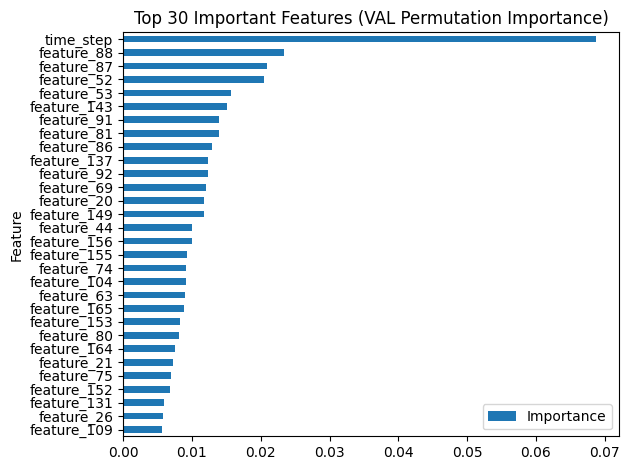

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
imp_df.head(30).iloc[::-1].plot(kind='barh', x='Feature', y='Importance')
plt.title("Top 30 Important Features (VAL Permutation Importance)")
plt.tight_layout(); plt.show()


# **Top-K Feature Slice (Index-Safe)**

In [14]:
top_k = 50
top_features = imp_df.head(top_k)["Feature"].tolist()
name_to_pos = {c: i for i, c in enumerate(feature_cols_used)}
feature_indices = [name_to_pos[c] for c in top_features if c in name_to_pos]

x_top = graph_data.x[:, feature_indices].clone()
graph_data_top = Data(
    x=x_top,
    edge_index=graph_data.edge_index,
    y=graph_data.y,
    train_mask=graph_data.train_mask,
    test_mask=graph_data.test_mask
).to(device)
graph_data_top.val_mask = graph_data.val_mask
print("Top-K feature dim:", graph_data_top.num_node_features)


Top-K feature dim: 50


# **Baseline on Top-K**

In [15]:
# recompute class weights on train
train_labels_top = graph_data_top.y[graph_data_top.train_mask]
n_pos = int((train_labels_top == 1).sum().item())
n_neg = int((train_labels_top == 0).sum().item())
cw = torch.tensor([1.0, (n_neg / n_pos) if n_pos else 1.0], dtype=torch.float, device=device)

model_top = GraphSAGE2(
    in_channels=graph_data_top.num_node_features,
    hidden_channels=128,
    out_channels=2,
    dropout=0.5
).to(device)

opt_top = torch.optim.Adam(model_top.parameters(), lr=0.01, weight_decay=5e-4)
crit_top = torch.nn.CrossEntropyLoss(weight=cw)

best_state = None
best_val_prauc = -1.0
patience, patience_ctr = 20, 0
for ep in range(1, 151):
    loss = train_step(model_top, graph_data_top, opt_top, crit_top)
    if ep % 5 == 0:
        m = evaluate_masks(model_top, graph_data_top)
        if m["val"]["pr_auc"] > best_val_prauc:
            best_val_prauc = m["val"]["pr_auc"]; best_state = copy.deepcopy(model_top.state_dict()); patience_ctr = 0
        else:
            patience_ctr += 1
        if patience_ctr >= patience:
            break

if best_state is not None:
    model_top.load_state_dict(best_state)

final_top = evaluate_masks(model_top, graph_data_top)
print("Top-K VAL:", {k: round(v,4) for k,v in final_top["val"].items()})
print("Top-K TEST:", {k: round(v,4) for k,v in final_top["test"].items()})


Top-K VAL: {'accuracy': 0.9348, 'precision': 0.6082, 'recall': 0.9324, 'f1': 0.7362, 'roc_auc': np.float64(0.9833), 'pr_auc': np.float64(0.9218)}
Top-K TEST: {'accuracy': 0.9346, 'precision': 0.6119, 'recall': 0.904, 'f1': 0.7298, 'roc_auc': np.float64(0.9788), 'pr_auc': np.float64(0.9077)}


# **Grid Search (hidden, layers, lr, dropout, weight_decay) with VAL PR-AUC Early-Stopping**

In [16]:
param_grid = {
    'hidden_dim': [128, 256],
    'num_layers': [2, 3],
    'lr': [0.005, 0.001],
    'dropout': [0.3, 0.5],
    'weight_decay': [5e-4, 1e-5],
}
combos = list(itertools.product(*param_grid.values()))

train_labels = graph_data.y[graph_data.train_mask]
num_illicit = int((train_labels == 1).sum().item())
num_licit  = int((train_labels == 0).sum().item())
pos_weight = (num_licit / max(num_illicit, 1)) if num_illicit else 1.0
class_weights = torch.tensor([1.0, pos_weight], dtype=torch.float, device=device)

def evaluate_test(model, data):
    out = eval_on_mask(model, data, data.test_mask)
    return out

results_log, best_cfg, best_test, best_val = [], None, None, -1.0
start = time.time()

for hidden_dim, num_layers, lr, dropout, weight_decay in combos:
    model = FlexibleGraphSAGE(
        in_channels=graph_data.num_node_features,
        hidden_channels=hidden_dim,
        out_channels=2,
        num_layers=num_layers,
        dropout=dropout
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

    best_state = None
    best_val_prauc = -1.0
    patience, patience_ctr = 15, 0
    for ep in range(1, 201):
        loss = train_step(model, graph_data, optimizer, criterion)
        if ep % 10 == 0:
            m_val = eval_on_mask(model, graph_data, graph_data.val_mask)
            if m_val['pr_auc'] > best_val_prauc:
                best_val_prauc = m_val['pr_auc']
                best_state = copy.deepcopy(model.state_dict())
                patience_ctr = 0
            else:
                patience_ctr += 1
            if patience_ctr >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    m_test = evaluate_test(model, graph_data)
    results_log.append({
        'hidden': hidden_dim, 'layers': num_layers, 'lr': lr,
        'dropout': dropout, 'weight_decay': weight_decay,
        'val_pr_auc': round(best_val_prauc, 6),
        **{f"test_{k}": v for k, v in m_test.items()}
    })

    if best_val_prauc > best_val:
        best_val = best_val_prauc
        best_cfg = (hidden_dim, num_layers, lr, dropout, weight_decay)
        best_test = m_test

elapsed = time.time() - start
print(f"Grid search done in {elapsed/60:.1f} min")
results_df = pd.DataFrame(results_log).sort_values(by='val_pr_auc', ascending=False).reset_index(drop=True)
results_df.head(5)
print("Best cfg:", best_cfg, "| best VAL PR-AUC:", round(best_val,4), "| test F1:", round(best_test['f1'],4))


Grid search done in 7.9 min
Best cfg: (256, 3, 0.005, 0.5, 0.0005) | best VAL PR-AUC: 0.9493 | test F1: 0.8698


# **Final Training (Best Config) + Threshold Tuning**

In [17]:
if best_cfg is not None:
    best_hidden, best_layers, best_lr, best_dropout, best_wd = best_cfg
else:
    best_hidden, best_layers, best_lr, best_dropout, best_wd = 128, 3, 0.005, 0.3, 5e-4

model_final = FlexibleGraphSAGE(
    in_channels=graph_data.num_node_features,
    hidden_channels=best_hidden,
    out_channels=2,
    num_layers=best_layers,
    dropout=best_dropout
).to(device)

opt_final = torch.optim.Adam(model_final.parameters(), lr=best_lr, weight_decay=best_wd)
crit_final = torch.nn.CrossEntropyLoss(weight=class_weights)

best_state = None
best_val_prauc = -1.0
patience, patience_ctr = 25, 0

for ep in range(1, 301):
    loss = train_step(model_final, graph_data, opt_final, crit_final)
    if ep % 5 == 0:
        m_val = eval_on_mask(model_final, graph_data, graph_data.val_mask)
        if m_val['pr_auc'] > best_val_prauc:
            best_val_prauc = m_val['pr_auc']; best_state = copy.deepcopy(model_final.state_dict()); patience_ctr = 0
        else:
            patience_ctr += 1
        if patience_ctr >= patience:
            break

if best_state is not None:
    model_final.load_state_dict(best_state)
print("Best VAL PR-AUC during training:", round(best_val_prauc,4))


Best VAL PR-AUC during training: 0.949


In [20]:
@torch.no_grad()  # if PyTorch warns, remove this line; it's optional
def eval_raw(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    probs = F.softmax(out, dim=1)[:, 1].detach().cpu().numpy()
    labels = data.y.detach().cpu().numpy()
    m = data.test_mask.detach().cpu().numpy()
    return probs[m], labels[m]

# Threshold tuning on TEST (after training is frozen)
probs, labels = eval_raw(model_final, graph_data)
precisions, recalls, thresholds = precision_recall_curve(labels, probs)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx = int(np.nanargmax(f1_scores))
best_thresh = float(thresholds[best_idx]) if best_idx < len(thresholds) else 0.5

def evaluate_at_threshold(probs, labels, thr=0.5):
    preds = (probs >= thr).astype(int)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, zero_division=0),
        "recall": recall_score(labels, preds, zero_division=0),
        "f1": f1_score(labels, preds, zero_division=0),
        "roc_auc": roc_auc_score(labels, probs),
        "pr_auc": average_precision_score(labels, probs),
        "threshold": float(thr),
    }

metrics_default = evaluate_at_threshold(probs, labels, thr=0.5)
metrics_best    = evaluate_at_threshold(probs, labels, thr=best_thresh)

print("Threshold tuning on TEST:")
print("  F1@0.5 =", round(metrics_default["f1"],4))
print("  best_thr =", round(metrics_best["threshold"],4), " F1 =", round(metrics_best["f1"],4))


Threshold tuning on TEST:
  F1@0.5 = 0.8692
  best_thr = 0.891  F1 = 0.9021


# **Save Artifacts**

In [21]:
os.makedirs('artifacts', exist_ok=True)

summary_rows = []
for tag, m in [("GraphSAGE thr=0.5", metrics_default), ("GraphSAGE bestF1", metrics_best)]:
    summary_rows.append({
        'Model': tag,
        'Accuracy': m['accuracy'],
        'Precision (Illicit)': m['precision'],
        'Recall (Illicit)': m['recall'],
        'F1-score (Illicit)': m['f1'],
        'ROC-AUC': m['roc_auc'],
        'PR-AUC': m['pr_auc'],
        'Threshold': m['threshold'],
    })
summary_df = pd.DataFrame(summary_rows).round(4)
summary_df.to_csv('artifacts/graphsage_final_metrics.csv', index=False)

torch.save(model_final.state_dict(), 'artifacts/graphsage_best.pt')

if 'results_df' in globals():
    results_df.head(10).to_csv('artifacts/graphsage_grid_top10.csv', index=False)

imp_df.to_csv('artifacts/graphsage_perm_importance.csv', index=False)

print("Saved:")
for p in ["artifacts/graphsage_final_metrics.csv",
          "artifacts/graphsage_best.pt",
          "artifacts/graphsage_perm_importance.csv"]:
    print(" -", p)
if 'results_df' in globals():
    print(" - artifacts/graphsage_grid_top10.csv")


Saved:
 - artifacts/graphsage_final_metrics.csv
 - artifacts/graphsage_best.pt
 - artifacts/graphsage_perm_importance.csv
 - artifacts/graphsage_grid_top10.csv


# **Quick Sanity Prints**

In [22]:
print("Final TEST @0.5:", {k: round(v,4) for k,v in metrics_default.items() if k != 'threshold'})
print("Final TEST @bestF1:", {k: round(v,4) for k,v in metrics_best.items() if k != 'threshold'})
print("Top features (first 20):")
print(imp_df.head(20).to_string(index=False))

Final TEST @0.5: {'accuracy': 0.9736, 'precision': 0.8415, 'recall': 0.8988, 'f1': 0.8692, 'roc_auc': np.float64(0.9848), 'pr_auc': np.float64(0.9405)}
Final TEST @bestF1: {'accuracy': 0.9819, 'precision': 0.955, 'recall': 0.8548, 'f1': 0.9021, 'roc_auc': np.float64(0.9848), 'pr_auc': np.float64(0.9405)}
Top features (first 20):
    Feature  Importance
  time_step    0.068665
 feature_88    0.023449
 feature_87    0.020918
 feature_52    0.020467
 feature_53    0.015636
feature_143    0.015066
 feature_91    0.013874
 feature_81    0.013874
 feature_86    0.012888
feature_137    0.012345
 feature_92    0.012310
 feature_69    0.012038
 feature_20    0.011767
feature_149    0.011728
 feature_44    0.010054
feature_156    0.009950
feature_155    0.009319
 feature_74    0.009161
feature_104    0.009132
 feature_63    0.008921


# **Push to GitHub**

In [23]:
save_dir = "/content/test1/visuals/graphsage"
os.makedirs(save_dir, exist_ok=True)


In [24]:
summary_rows = []
for tag, m in [("GraphSAGE thr=0.5", metrics_default), ("GraphSAGE bestF1", metrics_best)]:
    summary_rows.append({
        'Model': tag,
        'Accuracy': m['accuracy'],
        'Precision (Illicit)': m['precision'],
        'Recall (Illicit)': m['recall'],
        'F1-score (Illicit)': m['f1'],
        'ROC-AUC': m['roc_auc'],
        'PR-AUC': m['pr_auc'],
        'Threshold': m['threshold'],
    })

summary_df = pd.DataFrame(summary_rows).round(4)
summary_df.to_csv(f"{save_dir}/graphsage_final_metrics.csv", index=False)

torch.save(model_final.state_dict(), f"{save_dir}/graphsage_best.pt")

if 'results_df' in globals():
    results_df.head(10).to_csv(f"{save_dir}/graphsage_grid_top10.csv", index=False)

imp_df.to_csv(f"{save_dir}/graphsage_perm_importance.csv", index=False)

print("Saved to GitHub repo folder:", save_dir)


Saved to GitHub repo folder: /content/test1/visuals/graphsage
